
In this notebook, we will 
- Learn how to use BoostedTrees Classifier for training and evaluating
- Explore how training can be speeded up for small datasets
- Will develop intuition for how some of the hyperparameters affect the performance of boosted trees.


In [1]:
# We will use some np and pandas for dealing with input data.
import numpy as np
import pandas as pd
# And of course, we need tensorflow.
import tensorflow as tf

from distutils.version import StrictVersion

In [2]:
tf.__version__

'2.3.0'

In [5]:
#tf.logging.set_verbosity(tf.logging.INFO)
tf.random.set_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [7]:
dftrain.head(3)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y


In [8]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


In [10]:
dftrain.isna().sum()

sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [11]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [20]:
fcol = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fcol.indicator_column(
      fcol.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
fc = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  fc.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  fc.append(fcol.numeric_column(feature_name,
                                dtype=tf.float32))

In [13]:
# Prepare the input fn. Use the entire dataset for a batch since this is such a small dataset.

def make_input_fn(X, y, n_epochs=None, do_batching=True):
  def input_fn():
    BATCH_SIZE = len(y)
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)  
    if do_batching:
      dataset = dataset.batch(BATCH_SIZE)
    return dataset
  return input_fn

In [14]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':10,
  'center_bias':False,
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


In [27]:
# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)


In [28]:
est = tf.estimator.BoostedTreesClassifier(fc,
                                          n_batches_per_layer=n_batches_per_layer,
                                          **params)

est.train(train_input_fn)

# Eval.
pd.Series(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpv8_360am', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


accuracy                 0.821970
accuracy_baseline        0.625000
auc                      0.862473
auc_precision_recall     0.847146
average_loss             0.422375
label/mean               0.375000
loss                     0.422375
precision                0.788889
prediction/mean          0.384808
recall                   0.717172
global_step             60.000000
dtype: float64

In [29]:
# Training and evaluation input functions.
est = tf.estimator.DNNClassifier([10], fc)
est.train(train_input_fn, max_steps=1000)
pd.Series(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4c8kdoy_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


accuracy                   0.693182
accuracy_baseline          0.625000
auc                        0.650168
auc_precision_recall       0.521028
average_loss               0.643523
label/mean                 0.375000
loss                       0.643523
precision                  0.632353
prediction/mean            0.358916
recall                     0.434343
global_step             1000.000000
dtype: float64

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4c8kdoy_/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


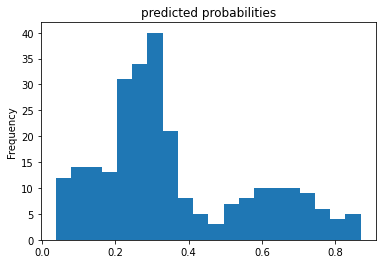

In [30]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

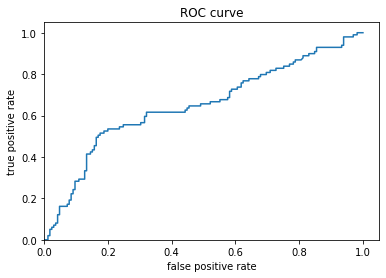

In [31]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);